# Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from PIL import Image

from scipy.stats import chi2_contingency, ttest_ind
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb

import itertools
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# import a font

In [2]:
# Path of the uploaded font file
FONT_PATH = '/home/blacktea/Downloads/Tung/Study/Font/Times New Roman.ttf'
# Load the font
fm.fontManager.addfont(FONT_PATH)

# Set the font
plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to "Times New Roman"
plt.rcParams['font.size'] = 12  # Set the font size to 12

# Upload data

In [3]:
BASE_PATH = '/home/blacktea/Downloads/Tung/Study/paper/OSA and Osteoporosis'
INPUT_PATH = f'{BASE_PATH}/Data Set'
file_name = '2017-2022-search.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(f'{INPUT_PATH}/{file_name}')

# Data preprocessing

In [4]:
# Total count before processing
initial_count = len(df)
print(f'Total number of records before processing: {initial_count} \n')

# Remove NaN values from the BMI column
bmi_null_count = df['BMI'].isna().sum()
df = df.dropna(subset=['BMI'])
print(f'Number of records with BMI NaN values removed: {bmi_null_count}')
print(f'Total number of records after removing BMI NaN values: {len(df)} \n')

# Remove records with BMI out of a reasonable range (BMI >= 18.5 and <= 60)
bmi_out_of_range_count = df[(df['BMI'] < 18.5) | (df['BMI'] > 60)].shape[0]
df = df[(df['BMI'] >= 18.5) & (df['BMI'] <= 60)]
print(f'Number of records with BMI out of reasonable range (BMI < 18.5 or BMI > 60) removed: {bmi_out_of_range_count}')
print(f'Total number of records after keeping BMI within reasonable range: {len(df)} \n')

# Remove records with age out of a reasonable range (age >= 50 and <= 85)
age_out_of_range_count = df[(df['age'] < 50) | (df['age'] > 85)].shape[0]
df = df[(df['age'] >= 50) & (df['age'] <= 85)]
print(f'Number of records with age out of reasonable range (age < 50 or age > 85) removed: {age_out_of_range_count}')
print(f'Total number of records after keeping age within reasonable range: {len(df)} \n')

# Remove NaN values from the SA_result column
sa_result_null_count = df['OSA_result'].isna().sum()
df = df.dropna(subset=['OSA_result'])
print(f'Number of records with OSA_result NaN values removed: {sa_result_null_count}')
print(f'Total number of records after removing OSA_result NaN values: {len(df)} \n')

# Final total number of records after processing
final_count = len(df)
print(f'Total number of records after final processing: {final_count}')
print(f'Total number of records removed: {initial_count - final_count}')

Total number of records before processing: 5480 

Number of records with BMI NaN values removed: 607
Total number of records after removing BMI NaN values: 4873 

Number of records with BMI out of reasonable range (BMI < 18.5 or BMI > 60) removed: 147
Total number of records after keeping BMI within reasonable range: 4726 

Number of records with age out of reasonable range (age < 50 or age > 85) removed: 269
Total number of records after keeping age within reasonable range: 4457 

Number of records with OSA_result NaN values removed: 0
Total number of records after removing OSA_result NaN values: 4457 

Total number of records after final processing: 4457
Total number of records removed: 1023


# Models

In [5]:
models = {
    'LR': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(class_weight='balanced'))
    ]),
    'RF': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42),
    'XGBoost': xgb.XGBClassifier(scale_pos_weight=50, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=42),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42))
    ])
}

colors = {'LR': 'red', 'RF': 'blue', 'XGBoost': 'green', 'AdaBoost': 'purple', 'SVM': 'brown'}

# Function area

In [6]:
# Function to calculate p-value for categorical features using Chi-square test
def calculate_p_value(df, column, target_col):
    contingency_table = pd.crosstab(df[column], df[target_col])  # Create a contingency table
    _, p_value, _, _ = chi2_contingency(contingency_table)  # Perform Chi-square test
    return p_value

# Function to analyze features, both continuous and categorical
def analyze_features(df, target_col='OSA_result', features=None, max_categories=20):
    if features is None:
        features = df.columns.tolist()  # If no features are specified, default to all columns
    else:
        df = df[features + [target_col]]  # Keep only the specified features along with the target column

    results_continuous = []  # List to store results for continuous features
    results_categorical = []  # List to store results for categorical features

    for col in features:
        if col == target_col:
            continue  # Skip the target column

        # Continuous feature analysis
        if pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() > 10:
            overall_mean = df[col].mean()  # Mean of the entire column
            overall_std = df[col].std()  # Standard deviation of the entire column
            group_stats = df.groupby(target_col)[col].agg(['mean', 'std']).reset_index()  # Mean and std by group
            group_0 = df[df[target_col] == 0][col].dropna()  # Group 0 (OSA negative) values
            group_1 = df[df[target_col] == 1][col].dropna()  # Group 1 (OSA positive) values
            t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)  # Perform t-test between the two groups

            # Round results for easier presentation
            Overall_Mean = round(overall_mean, 2)
            Overall_Std = round(overall_std, 2)
            Group_0_Mean = round(group_stats.loc[group_stats[target_col] == 0, 'mean'].values[0], 2)
            Group_0_Std = round(group_stats.loc[group_stats[target_col] == 0, 'std'].values[0], 2)
            Group_1_Mean = round(group_stats.loc[group_stats[target_col] == 1, 'mean'].values[0], 2)
            Group_1_Std = round(group_stats.loc[group_stats[target_col] == 1, 'std'].values[0], 2)

            # Store the results for continuous features
            results_continuous.append({
                'Feature': col,
                'Overall Mean': Overall_Mean,
                'Overall Std': Overall_Std,
                'Overall (mean - 2*std)': Overall_Mean - 2 * Overall_Std,
                'Overall (mean + 2*std)': Overall_Mean + 2 * Overall_Std,
                'Group 1 Mean': Group_1_Mean,
                'Group 1 Std': Group_1_Std,
                'Group 1 (mean - 2*std)': Group_1_Mean - 2 * Group_1_Std,
                'Group 1 (mean + 2*std)': Group_1_Mean + 2 * Group_1_Std,
                'Group 0 Mean': Group_0_Mean,
                'Group 0 Std': Group_0_Std,
                'Group 0 (mean - 2*std)': Group_0_Mean - 2 * Group_0_Std,
                'Group 0 (mean + 2*std)': Group_0_Mean + 2 * Group_0_Std,
                'T-test p-value': round(p_val, 4)  # T-test p-value for the difference between the groups
            })

        # Categorical feature analysis (if the number of unique categories is <= max_categories)
        elif df[col].nunique() <= max_categories:
            counts = pd.crosstab(df[col], df[target_col], margins=True)  # Create a contingency table
            p_value = calculate_p_value(df, col, target_col)  # Calculate p-value for categorical feature

            # Iterate through each category (excluding the "All" row)
            for category in counts.index[:-1]:
                total = counts.loc[category, 'All']  # Total count for the category
                osa_positive = counts.loc[category, 1]  # Count of OSA positive samples
                osa_negative = counts.loc[category, 0]  # Count of OSA negative samples

                # Store the results for categorical features
                results_categorical.append({
                    'Feature': col,
                    'Category': category,
                    'Total Count': f"{total} ({(total / len(df)) * 100:.2f})",  # Total count and percentage
                    'OSA Positive': f"{osa_positive} ({(osa_positive / total) * 100:.2f})",  # OSA positive count and percentage
                    'OSA Negative': f"{osa_negative} ({(osa_negative / total) * 100:.2f})",  # OSA negative count and percentage
                    'p-value': f"{p_value:.2e}" if category == counts.index[0] else ''  # P-value (only shown for the first category)
                })

    # Convert the results to DataFrame for easier presentation
    results_continuous_df = pd.DataFrame(results_continuous)
    results_categorical_df = pd.DataFrame(results_categorical)

    return results_continuous_df, results_categorical_df

def train_model_cv(X, y, cv=10):
    """Train using Cross-Validation and measure time"""

    # Find the maximum string length
    max_name_length = max(len(name) for name in models.keys())

    # Print the separator with the same length as the accuracy message
    print("=" * len(f"Accuracy of train set (CV {cv} times)"))
    print(f"Accuracy of train set (CV {cv} times)")

    for name, model in models.items():
        acc_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

        # Calculate average accuracy
        avg_acc = acc_scores.mean()

        # Display the results
        print("-" * len(f"Accuracy of train set (CV {cv} times)"))
        print(f"{name: <{max_name_length}} | {avg_acc:.4f}")

    print("=" * len(f"Accuracy of train set (CV {cv} times)"))

def plt_roc_curve_cv(X, y, cv, filename, dpi=300):
    """Calculate and plot ROC curve using Cross-Validation and save as eps with dpi=300"""
    plt.figure(figsize=(8, 6))

    for name, model in models.items():
        # Use Cross-Validation to get predicted probabilities (predict_proba)
        y_pred_prob = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]

        # Calculate ROC curve and AUC score
        fpr, tpr, _ = roc_curve(y, y_pred_prob)
        auc_score = roc_auc_score(y, y_pred_prob)

        # Plot ROC curve with optional color
        plt.plot(fpr, tpr, color=colors[name], label=f'AUC = {auc_score:.4f}, {name}')

    # Plot diagonal line (no skill line)
    plt.plot([0, 1], [0, 1], 'k--')

    # Set plot title and labels
    plt.title(f'ROC Curve (CV {cv} folds)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Display legend
    plt.legend(loc='lower right')
    # Save the figure as a .eps file with specified DPI
    plt.savefig(filename, format='eps', dpi=dpi)
    # Show the plot
    plt.show()

def train_model(X_train, X_valid, y_train, y_valid):
    # Find the maximum string length
    max_name_length = max(len(name) for name in models.keys())

    # Print the separator with the same length as the accuracy message
    print("=" * len(f"Accuracy of validation set"))
    print("Accuracy of validation set")

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)

        # Calculate accuracy
        acc = accuracy_score(y_valid, y_pred)

        # Display the results
        print("-" * len(f"Accuracy of test set"))
        print(f"{name: <{max_name_length}} | {acc:.4f}")

    print("=" * len(f"Accuracy of validation set"))

def plt_roc_curve(X_valid, y_valid, filename, dpi=300):
   plt.figure(figsize=(8, 6))

   for name, model in models.items():
       y_pred_prob = model.predict_proba(X_valid)[:, 1]

       fpr, tpr, _ = roc_curve(y_valid, y_pred_prob)
       auc_score = roc_auc_score(y_valid, y_pred_prob)
       plt.plot(fpr, tpr, color=colors[name], label=f'AUC = {auc_score:.4f}, {name}')

   plt.plot([0, 1], [0, 1], 'k--')
   plt.title('ROC Curve of validation set')
   plt.xlabel('False Positive Rate')
   plt.ylabel('True Positive Rate')
   # Display legend
   plt.legend(loc='lower right')
   # Save the figure as a .eps file with specified DPI
   plt.savefig(filename, format='eps', dpi=dpi)
   # Show the plot
   plt.show()

# Add T-score grouping
def tscore_grouping(tscore):
    if tscore < -2.5:
        return 2
    elif -2.5 <= tscore <= -1:
        return 1
    else:
        return 0

def plot_correlation_matrix(df, features, filename, dpi):
    corr_matrix = df[features].corr()
    plt.figure(figsize=(8, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
    plt.title("Correlation Matrix")
    # Save the figure as a .tif file with specified DPI
    plt.savefig(filename, format='eps', dpi=dpi)
    # Show the plot
    plt.show()

def calculate_vif(df, features):
    X = add_constant(df[features])  # Add the intercept term
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_data = vif_data[vif_data["Feature"] != "const"]

    return vif_data

def filter_by_multiple_ranges(X, y, class_names, start_values, end_values):
    # Initialize filter condition and ensure index alignment
    filter_condition = pd.Series(True, index=X.index)

    # Update the filter condition based on the ranges
    for class_name, start, end in zip(class_names, start_values, end_values):

        filter_condition &= (X[class_name] >= start) & (X[class_name] <= end)

    # Apply the filter condition to the data
    filtered_X = X[filter_condition]
    filtered_y = y[filter_condition]

    # Check the filter result
    if filtered_y.sum() == 0:
        return None, None

    return filtered_X, filtered_y

def calculate_auc_cv_filter(X_train, X_valid, y_train, y_valid, class_names, start_values, end_values, cv, models, mode):
    results = []  # Store the AUC for each range and model

    # Initialize auc_scores before using it in both train and test mode
    auc_scores = {name: [] for name in models.keys()}  # Store AUC scores for each model

    if mode == 'train':
        skf = StratifiedKFold(n_splits=cv)

        for train_idx, test_idx in skf.split(X_train, y_train):
            X_tr, X_ts = X_train.iloc[train_idx], X_train.iloc[test_idx]
            y_tr, y_ts = y_train.iloc[train_idx], y_train.iloc[test_idx]

            # Filter validation set based on all feature ranges at once
            filtered_X_ts, filtered_y_ts = filter_by_multiple_ranges(X_ts, y_ts, class_names, start_values, end_values)
            if filtered_X_ts is None or filtered_y_ts is None:
                continue

            for name, model in models.items():
                model.fit(X_tr, y_tr)
                y_pred_prob = model.predict_proba(filtered_X_ts)[:, 1]
                auc = roc_auc_score(filtered_y_ts, y_pred_prob)
                auc_scores[name].append(auc)

        # Calculate the average AUC for each model and range
        for name, scores in auc_scores.items():
            avg_auc = np.mean(scores) if scores else None
            feature_range = tuple(zip(class_names, zip(start_values, end_values)))  # Combine features with their ranges
            if avg_auc is not None:
                results.append({'Feature': feature_range, 'Model': name, 'AUC': f"{avg_auc:.4f}"})
            else:
                results.append({'Feature': feature_range, 'Model': name, 'AUC': 'No valid AUC'})

    if mode == 'valid':
        filtered_X_valid, filtered_y_valid = filter_by_multiple_ranges(X_valid, y_valid, class_names, start_values, end_values)

        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred_prob = model.predict_proba(filtered_X_valid)[:, 1]
            auc = roc_auc_score(filtered_y_valid, y_pred_prob)
            feature_range = tuple(zip(class_names, zip(start_values, end_values)))  # Combine features with their ranges
            if auc is not None:
                results.append({'Feature': feature_range, 'Model': name, 'AUC': f"{auc:.4f}"})
            else:
                results.append({'Feature': feature_range, 'Model': name, 'AUC': 'No valid AUC'})

    return pd.DataFrame(results)

def create_auc_dataframe(results, feature_group):
    """
    Organizes the AUC results for a feature group into a DataFrame.
    """
    # Filter the data for the specified feature group
    feature_data = results[results['Feature'].apply(lambda x: set(feature_group).issubset(set(dict(x).keys())))]

    # Extract unique feature ranges
    ranges = feature_data['Feature'].unique()
    models = feature_data['Model'].unique()

    # Create a DataFrame with one column per range
    auc_data = pd.DataFrame(index=models, columns=[str(dict(r)) for r in ranges])

    for model in models:
        model_data = feature_data[feature_data['Model'] == model]
        for r in ranges:
            auc_value = model_data[model_data['Feature'] == r]['AUC'].values

            # Check if AUC value exists and assign
            if auc_value.size > 0:
                auc_data.loc[model, str(dict(r))] = auc_value[0]
            else:
                auc_data.loc[model, str(dict(r))] = "No valid AUC"  # If no valid AUC, mark as "No valid AUC"

    return auc_data

def bmi_group_stats(df):
    # Define BMI groups
    bins = [18.5, 24, 27, 30, 35, 60]
    labels = ['(18.5, 24)', '(24, 27)', '(27, 30)', '(30, 35)', '(35, 60)']
    df['BMI_group'] = pd.cut(df['BMI'], bins=bins, labels=labels, right=False)

    # ===== Statistics for OSA groups =====
    grouped_with_osa = df.groupby(['BMI_group', 'OSA_result']).agg({
        'bmd': ['mean', 'std'],
        'tscore': ['mean', 'std']
    })
    grouped_with_osa.columns = ['BMD_mean', 'BMD_std', 'Tscore_mean', 'Tscore_std']
    grouped_with_osa = grouped_with_osa.reset_index()
    grouped_with_osa['BMD_mean ± 2SD'] = grouped_with_osa['BMD_mean'].round(2).astype(str) + ' ± ' + (2 * grouped_with_osa['BMD_std']).round(2).astype(str)
    grouped_with_osa['T-score_mean ± 2SD'] = grouped_with_osa['Tscore_mean'].round(2).astype(str) + ' ± ' + (2 * grouped_with_osa['Tscore_std']).round(2).astype(str)
    grouped_with_osa = grouped_with_osa[['BMI_group', 'OSA_result', 'BMD_mean ± 2SD', 'T-score_mean ± 2SD']]

    # ===== Overall statistics (without OSA) =====
    grouped_overall = df.groupby('BMI_group').agg({
        'bmd': ['mean', 'std'],
        'tscore': ['mean', 'std']
    })
    grouped_overall.columns = ['BMD_mean', 'BMD_std', 'Tscore_mean', 'Tscore_std']
    grouped_overall = grouped_overall.reset_index()
    grouped_overall['BMD_mean ± 2SD'] = grouped_overall['BMD_mean'].round(2).astype(str) + ' ± ' + (2 * grouped_overall['BMD_std']).round(2).astype(str)
    grouped_overall['T-score_mean ± 2SD'] = grouped_overall['Tscore_mean'].round(2).astype(str) + ' ± ' + (2 * grouped_overall['Tscore_std']).round(2).astype(str)
    grouped_overall['OSA_result'] = 'Overall'
    grouped_overall = grouped_overall[['BMI_group', 'OSA_result', 'BMD_mean ± 2SD', 'T-score_mean ± 2SD']]

    # ===== Combine both results (optional) =====
    df_result = pd.concat([grouped_with_osa, grouped_overall], ignore_index=True)

    return df_result

# Data Information

In [9]:
# Apply the tscore_grouping function to the `tscore` column and store the result in a new column `T-score_group`.
df['T-score_group'] = df['tscore'].apply(tscore_grouping)

# Define a list of feature variables: `Gender`, `age`, `BMI`, `bmd`, `tscore`, and the newly added `T-score_group`.
features = ['Gender', 'age', 'BMI', 'bmd', 'tscore', 'T-score_group']

# Perform analysis using the analyze_features function.
# Set the target variable as `OSA_result`, and separate the analysis results into continuous and categorical features.
results_continuous, results_categorical = analyze_features(df, target_col='OSA_result', features=features)

# Print the analysis results for continuous features.
print("Continuous Features Analysis:")
print(results_continuous, '\n')

# Print the analysis results for categorical features.
print("Categorical Features Analysis:")
print(results_categorical)

Continuous Features Analysis:
  Feature  Overall Mean  Overall Std  Overall (mean - 2*std)  \
0     age         67.84         9.38                   49.08   
1     BMI         26.01         4.14                   17.73   
2     bmd          0.93         0.11                    0.71   
3  tscore         -2.02         0.95                   -3.92   

   Overall (mean + 2*std)  Group 1 Mean  Group 1 Std  Group 1 (mean - 2*std)  \
0                   86.60         62.47         8.39                   45.69   
1                   34.29         27.66         4.52                   18.62   
2                    1.15          1.01         0.11                    0.79   
3                   -0.12         -1.37         0.92                   -3.21   

   Group 1 (mean + 2*std)  Group 0 Mean  Group 0 Std  Group 0 (mean - 2*std)  \
0                   79.25         68.95         9.20                   50.55   
1                   36.70         25.67         3.98                   17.71   
2       

In [7]:
df_result = bmi_group_stats(df)
print(df_result)

     BMI_group OSA_result BMD_mean ± 2SD T-score_mean ± 2SD
0   (18.5, 24)          0    0.89 ± 0.22        -2.4 ± 1.82
1   (18.5, 24)          1    0.96 ± 0.25       -1.79 ± 2.09
2     (24, 27)          0     0.92 ± 0.2       -2.13 ± 1.69
3     (24, 27)          1    1.01 ± 0.21       -1.39 ± 1.69
4     (27, 30)          0    0.94 ± 0.21       -1.95 ± 1.76
5     (27, 30)          1    1.02 ± 0.21       -1.27 ± 1.75
6     (30, 35)          0     0.95 ± 0.2       -1.86 ± 1.67
7     (30, 35)          1     1.04 ± 0.2       -1.15 ± 1.66
8     (35, 60)          0    0.96 ± 0.18       -1.79 ± 1.49
9     (35, 60)          1    1.05 ± 0.19       -1.04 ± 1.53
10  (18.5, 24)    Overall    0.89 ± 0.23       -2.34 ± 1.88
11    (24, 27)    Overall    0.93 ± 0.21       -2.01 ± 1.78
12    (27, 30)    Overall    0.96 ± 0.22        -1.8 ± 1.85
13    (30, 35)    Overall    0.97 ± 0.22       -1.68 ± 1.78
14    (35, 60)    Overall     0.99 ± 0.2        -1.5 ± 1.67


# Not Feature selection

Accuracy of train set (CV 10 times)
-----------------------------------
LR       | 0.7784
-----------------------------------
RF       | 0.8574
-----------------------------------
XGBoost  | 0.7228
-----------------------------------
AdaBoost | 0.8611
-----------------------------------
SVM      | 0.8050


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


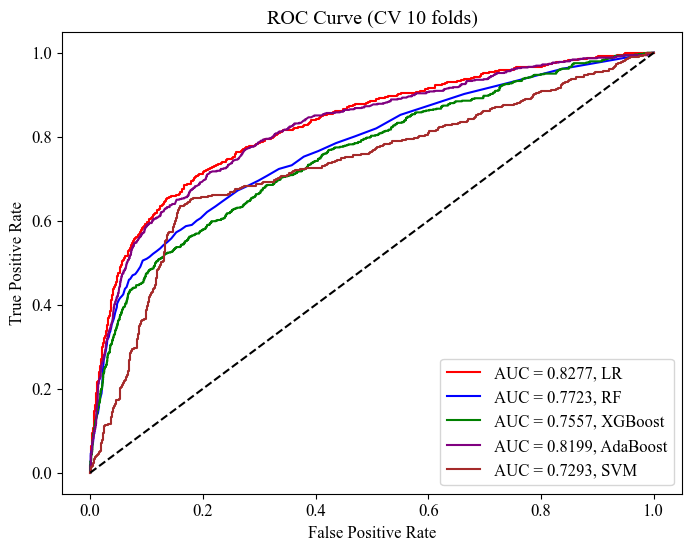

In [11]:
# Set the target variable and feature variables
y = df['OSA_result']  # Target variable
X = df[['Gender', 'age', 'BMI', 'bmd']]  # Feature variables

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

#------------------------------------------------------------------------------------------------
train_model_cv(X_train, y_train, cv=10)
plt_roc_curve_cv(X_train, y_train, cv=10, filename='Fig 2.eps', dpi=300)

Accuracy of validation set
--------------------
LR       | 0.7960
--------------------
RF       | 0.8408
--------------------
XGBoost  | 0.7265
--------------------
AdaBoost | 0.8520


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


--------------------
SVM      | 0.8318


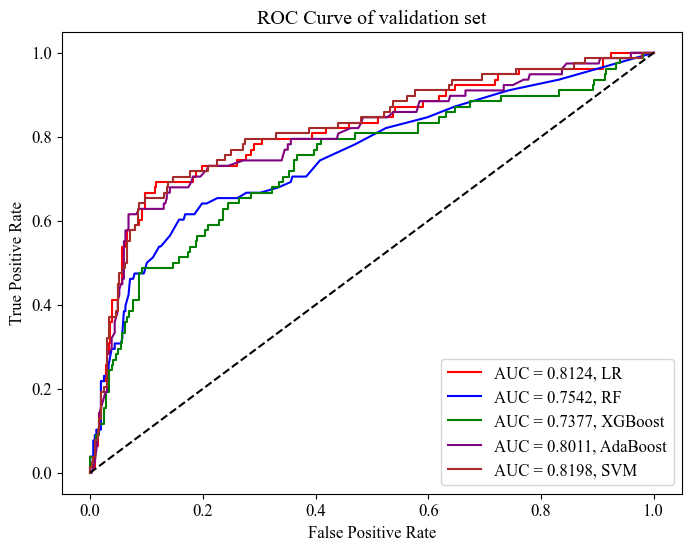

In [12]:
train_model(X_train, X_valid, y_train, y_valid)
plt_roc_curve(X_valid, y_valid, filename='Fig 3.eps', dpi=300)

# Feature selection

first step:



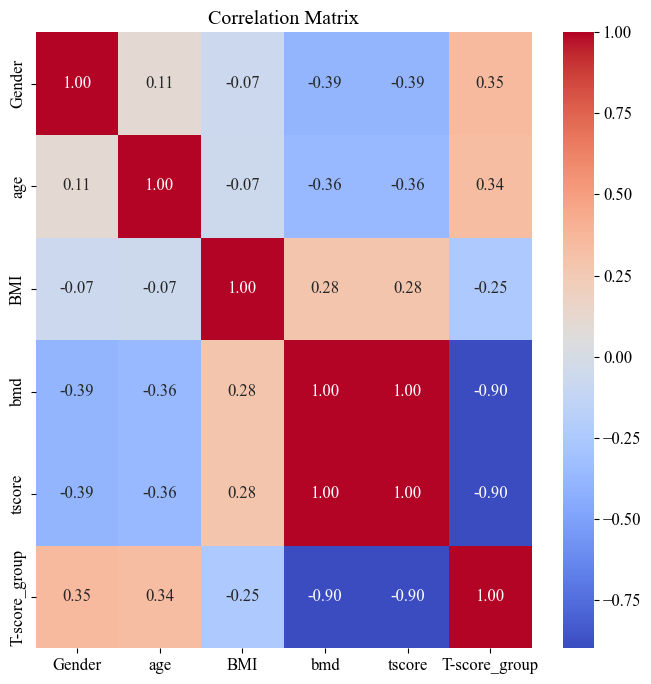


         Feature          VIF
1         Gender     1.184621
2            age     1.158533
3            BMI     1.094508
4            bmd  1449.768242
5         tscore  1471.013420
6  T-score_group     5.291689

second step:



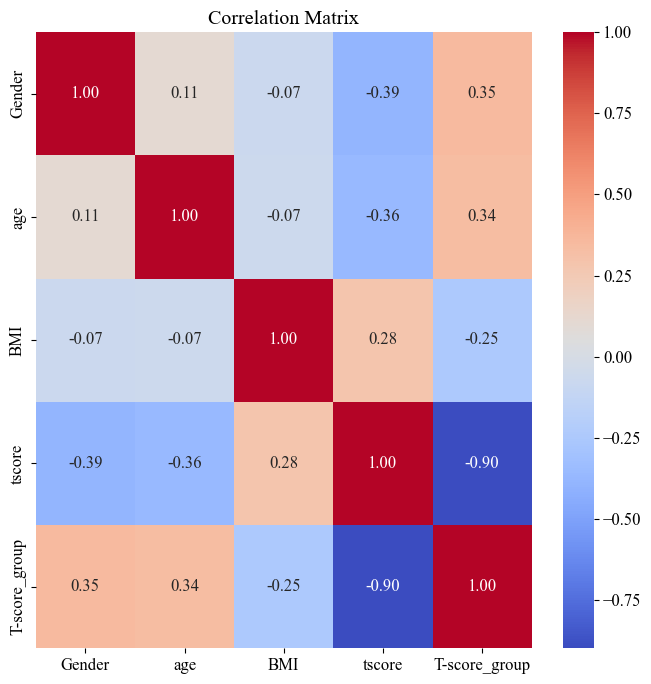


         Feature       VIF
1         Gender  1.184621
2            age  1.158451
3            BMI  1.093068
4         tscore  5.670614
5  T-score_group  5.240714

final step:



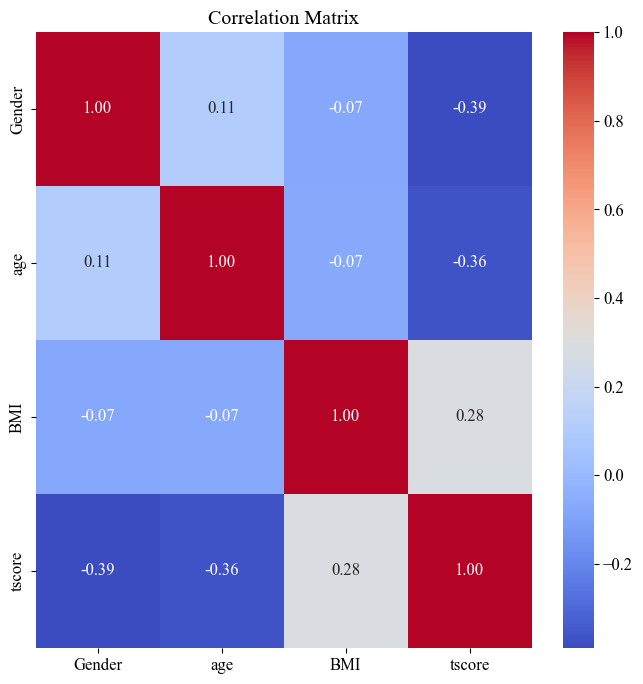


  Feature       VIF
1  Gender  1.184542
2     age  1.157863
3     BMI  1.092748
4  tscore  1.460502



In [13]:
# Apply the tscore_grouping function to the `tscore` column and store the result in a new column `T-score_group`.
df['T-score_group'] = df['tscore'].apply(tscore_grouping)

# Assume 'Gender' is a categorical variable.
encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' prevents multicollinearity.
encoded_vars = encoder.fit_transform(df[['Gender', 'T-score_group']])
encoded_df = pd.DataFrame(encoded_vars, columns=encoder.get_feature_names_out(['Gender', 'T-score_group']))

# Merge the encoded variables.
df_encoded = pd.concat([df.drop(columns=['Gender', 'T-score_group']), encoded_df], axis=1)

# Define feature sets for different steps.
features = {
    'first': ['Gender', 'age', 'BMI', 'bmd', 'tscore', 'T-score_group'],
    'second': ['Gender', 'age', 'BMI', 'tscore', 'T-score_group'],
    'final': ['Gender', 'age', 'BMI', 'tscore']
}

step_count = 0
# Iterate through feature sets and perform analysis.
for step, feature in features.items():
    print(f'{step} step:\n')
    if step == 'second':
        step_count = step_count
        # Plot the correlation matrix for the selected features.
        plot_correlation_matrix(df, feature, filename=f'Fig_{step}.eps', dpi=300)
    else:
        step_count += 1
        plot_correlation_matrix(df, feature, filename=f'Fig {step_count +3}.eps', dpi=300)

    # Calculate the Variance Inflation Factor (VIF) for the selected features.
    vif_results = calculate_vif(df, feature)
    print(f'\n{vif_results}\n')

Accuracy of train set (CV 10 times)
-----------------------------------
LR       | 0.7784
-----------------------------------
RF       | 0.8566
-----------------------------------
XGBoost  | 0.7250
-----------------------------------
AdaBoost | 0.8631
-----------------------------------
SVM      | 0.8050


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


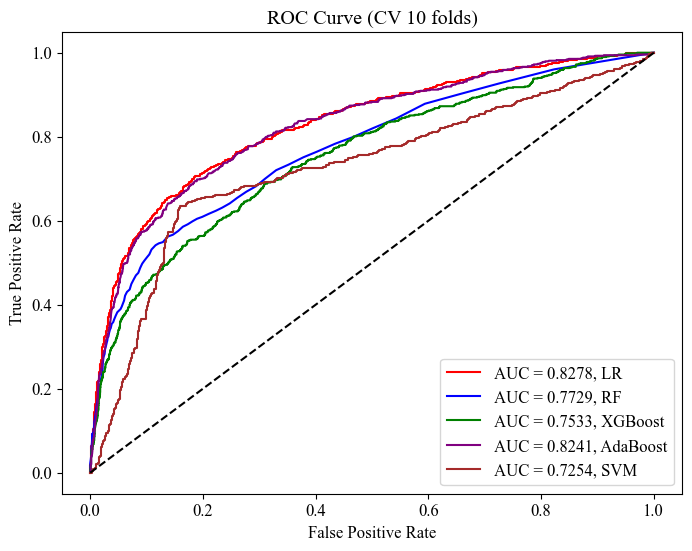

In [14]:
# Set the target variable and feature variables
y = df['OSA_result']  # Target variable
X = df[['Gender', 'age', 'BMI', 'tscore']]  # Feature variables

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

#------------------------------------------------------------------------------------------------
train_model_cv(X_train, y_train, cv=10)
plt_roc_curve_cv(X_train, y_train, cv=10, filename='Fig 6.eps', dpi=300)

Accuracy of validation set
--------------------
LR       | 0.7937
--------------------
RF       | 0.8363
--------------------
XGBoost  | 0.7175
--------------------
AdaBoost | 0.8520


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


--------------------
SVM      | 0.8318


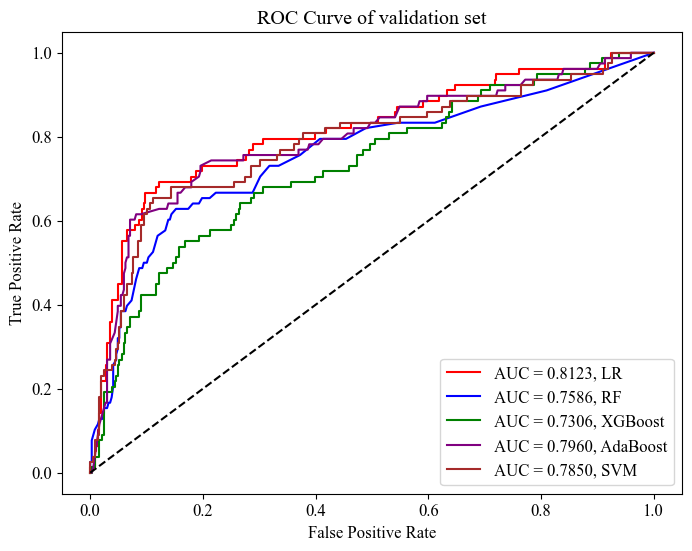

In [15]:
train_model(X_train, X_valid, y_train, y_valid)
plt_roc_curve(X_valid, y_valid, filename='Fig 7.eps', dpi=300)

# 1- Single feature interval

In [16]:
# Set the target variable and feature variables
y = df['OSA_result']  # Target variable
X = df[['Gender', 'age', 'BMI', 'tscore']]  # Feature variables
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [17]:
'''
parameter adjustment
'''

# Assume this is your features dictionary
features = {
    'age': [(50, 60), (60, 70), (70, 80), (80, 85), (50, 65)],  # Ranges for 'age'
    'BMI': [(18.5, 24), (24, 27), (27, 30), (30, 35), (35, 60)],  # Ranges for 'BMI'
    'tscore': [(-np.inf, -2.5), (-2.5, -1), (-1, np.inf)]  # Ranges for 'tscore'
}

k = 1  # Number of features in each combination
feature_combinations = list(itertools.combinations(features.keys(), k))  # Generate combinations of features

cv = 10  # Number of cross-validation folds

In [18]:
train_all_results = []  # Store results for all feature ranges in the training set
valid_all_results = []  # Store results for all feature ranges in the validation set

# Iterate over each feature combination (multiple features)
for feature_group in feature_combinations:
    # For each selected feature combination, get their respective ranges
    ranges = [features[feature] for feature in feature_group]

    # Get the Cartesian product of these ranges
    for range_combination in itertools.product(*ranges):
        # Extract the start and end values for each feature range
        start_values = [range_[0] for range_ in range_combination]
        end_values = [range_[1] for range_ in range_combination]

        # Calculate AUC for the training set
        train_result_df = calculate_auc_cv_filter(X_train, X_valid, y_train, y_valid, feature_group, start_values, end_values, cv, models, mode='train')
        train_all_results.append(train_result_df)

        # Calculate AUC for the validation set
        valid_result_df = calculate_auc_cv_filter(X_train, X_valid, y_train, y_valid, feature_group, start_values, end_values, cv, models, mode='valid')
        valid_all_results.append(valid_result_df)

# Combine individual results into final DataFrames for training and validation sets
train_final_results = pd.concat(train_all_results, ignore_index=True)
valid_final_results = pd.concat(valid_all_results, ignore_index=True)

# Create AUC tables for each feature combination
for feature_group in feature_combinations:
    # Generate AUC table based on the selected feature combination
    train_auc_table = create_auc_dataframe(train_final_results, feature_group)
    valid_auc_table = create_auc_dataframe(valid_final_results, feature_group)

    # Print the AUC table for the training set
    print('AUC Table of train set')
    print(f'{train_auc_table}\n')  # View the AUC table for the training set
    print('AUC Table of validation set')
    print(f'{valid_auc_table}\n')  # View the AUC table for the validation set

AUC Table of train set
         {'age': (50, 60)} {'age': (60, 70)} {'age': (70, 80)}  \
LR                  0.8334            0.7819            0.7364   
RF                  0.7877            0.7156            0.6837   
XGBoost             0.7576            0.6896            0.6597   
AdaBoost            0.8220            0.7779            0.7429   
SVM                 0.8004            0.7140            0.7035   

         {'age': (80, 85)} {'age': (50, 65)}  
LR                  0.7824            0.8254  
RF                  0.7099            0.7796  
XGBoost             0.6747            0.7445  
AdaBoost            0.7615            0.8201  
SVM                 0.7444            0.7787  

AUC Table of validation set
         {'age': (50, 60)} {'age': (60, 70)} {'age': (70, 80)}  \
LR                  0.7622            0.7680            0.7797   
RF                  0.7697            0.7410            0.6782   
XGBoost             0.7253            0.7166            0.6073   
AdaBo

# 2- two features interval

In [16]:
'''
parameter adjustment
'''

# Assume this is your features dictionary
features = {
    'age': [(50, 65)],
    'BMI': [(24, 27)],
    'tscore':[(-1, np.inf)]
}

k = 2
feature_combinations = list(itertools.combinations(features.keys(), k))

cv = 10

In [17]:
train_all_results = []  # Store results for all feature ranges
valid_all_results = []  # Store results for all feature ranges

# Iterate over each feature combination (multiple features)
for feature_group in feature_combinations:
    # For each selected feature combination, get their ranges
    ranges = [features[feature] for feature in feature_group]

    # Get the Cartesian product of these ranges
    for range_combination in itertools.product(*ranges):
        # Generate the start and end values for each feature
        start_values = [range_[0] for range_ in range_combination]
        end_values = [range_[1] for range_ in range_combination]

        # Calculate AUC for the training set
        train_result_df = calculate_auc_cv_filter(X_train, X_valid, y_train, y_valid, feature_group, start_values, end_values, cv, models, mode='train')
        train_all_results.append(train_result_df)

        # Calculate AUC for the validation set
        valid_result_df = calculate_auc_cv_filter(X_train, X_valid, y_train, y_valid, feature_group, start_values, end_values, cv, models, mode='valid')
        valid_all_results.append(valid_result_df)

# Combine the individual results for train and validation sets
train_final_results = pd.concat(train_all_results, ignore_index=True)
valid_final_results = pd.concat(valid_all_results, ignore_index=True)

# Create AUC tables for each feature combination
for feature_group in feature_combinations:
    # Generate AUC tables based on the selected feature combination
    train_auc_table = create_auc_dataframe(train_final_results, feature_group)
    valid_auc_table = create_auc_dataframe(valid_final_results, feature_group)

    # Print the AUC table for the training set
    print('AUC Table of train set')
    print(f'{train_auc_table}\n')  # View the AUC table for the training set
    print('AUC Table of validation set')
    print(f'{valid_auc_table}\n')  # View the AUC table for the validation set

AUC Table of train set
         {'age': (50, 65), 'BMI': (24, 27)}
LR                                   0.8301
RF                                   0.8054
XGBoost                              0.7504
AdaBoost                             0.8295
SVM                                  0.7886

AUC Table of validation set
         {'age': (50, 65), 'BMI': (24, 27)}
LR                                   0.8018
RF                                   0.8037
XGBoost                              0.7645
AdaBoost                             0.7806
SVM                                  0.7954

AUC Table of train set
         {'age': (50, 65), 'tscore': (-1, inf)}
LR                                       0.7944
RF                                       0.7767
XGBoost                                  0.7439
AdaBoost                                 0.7877
SVM                                      0.7772

AUC Table of validation set
         {'age': (50, 65), 'tscore': (-1, inf)}
LR                             